# Demo of Bio-RRMSE
### Comparing the performance of Bio-RRMSE to backprop on the FMNIST dataset in the online setting.

In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

### Loading the data and baseline performance

In [2]:
# The fashion MNIST dataset is saved in the accompanying file FMNIST_data.dmp. 
# The label data Y_train and Y_test are in one-hot format.
# In this example, we use the 10,000 test samples for the evaluation of our algorithm.

FMNIST_data = pkl.load( open( "FMNIST_data.dmp", "rb" ) )

X, Y = FMNIST_data['X_test'],FMNIST_data['Y_test']

X_dim = X.shape[0]; Y_dim = Y.shape[0]; num_samples = X.shape[1]

In [3]:
# As a preprocessing step, we subtract the mean of the labels.

Y = Y - Y.mean()

In [4]:
# We set the low-rank to 2 in this example.

Z_dim = 2

In [5]:
# The RRR algorithm using SVD is coded in RRR.py.
# The modes are RRMSE and CCA.
# Here, we compute the baseline performance of RRMSE,
# Using this exact SVD solution.
# We add a constant times identity to the X and Y correlation matrices for regulation.
# i.e. Cxx_reg = Cxx + 0.1 I, Cyy_reg = Cyy + 0.1 I.

from RRR import RRR

rrr_fitter = RRR(d=Z_dim,mode='rrmse',cov_reg = 0.1)
rrr_fitter.fit(X=X,Y=Y)

In [6]:
# The optimal value of the RRMSE objective is:

baseline = np.sum((Y - (rrr_fitter.y_weights.T)@(rrr_fitter.x_weights)@(X))**2)/num_samples
print('The optimal value of the RRMSE objective is: {:.2g}'.format(baseline))

The optimal value of the RRMSE objective is: 0.72


### Defining the training loop funciton

In [7]:
def run_rrmse( Z_dim, method = 'bio-rrmse', epochs = 10,
              eta_decay = 10000, eta_init = 0.0004, # learning rate and decay schedule
              Qratio = 1, Vyratio=1): # ratio of Vy and Q updates to Vx

    # plot points in log space
    plotspace = np.logspace(np.log10(2),np.log10(epochs*num_samples),11).astype(int) -1

    # Randomized sample draws
    idx = np.random.permutation(num_samples)

    # Initializing the weights of the algorithm
    Vx = np.random.randn(X_dim,Z_dim)/100; 
    Vy = np.random.randn(Y_dim,Z_dim)/10;
    Q = np.eye(Z_dim)/3
    
    hist_loss = []
    seen_samples_num = 0
    
    for epoch in range(epochs): # Epoch loop
        
        if epoch%2 == 0:
            print('Sample {}:'.format(seen_samples_num))
            print('Loss value: {:.5g}\n'.format(np.sum((Y - Vy@Vx.T@X)**2)/num_samples))
        
        for t in range(num_samples): # Sample loop

            # The current value of the decaying learning rate
            eta = eta_init * ( 1 / ( 1 + seen_samples_num/eta_decay ))
            
            if method.lower() == 'bio-rrmse':

                Z = Vx.T @ X[:,idx[t]]
                N = Q.T @ Z
                A = Vy.T @ Y[:,idx[t]]


                # The update rules given in Alg. 2
                # the extra factors of 0.1 are from the covariance regulation 
                # and are derived from Alg. 1 when replacing Cxx by 0.1.
                delta_Q = np.outer(Z, N) + 0.1 * Vx.T@Vx@Q - Q 
                delta_Vy = np.outer(Y[:,idx[t]],Z) - Vy
                delta_Vx = np.outer(X[:,idx[t]],A-Q@N) - 0.1*Vx@Q@Q.T
                
                Vx = Vx + eta * delta_Vx;
                Vy = Vy + Vyratio * eta * delta_Vy;
                Q = Q + Qratio * eta * delta_Q;
                
            elif method.lower() =='backprop':

                Z = Vx.T @ X[:,idx[t]]
                
                delta_Vy = np.outer(Y[:,idx[t]] - Vy@Z,Z) - 0.1 * Vy@Vx.T@Vx
                delta_Vx = np.outer(X[:,idx[t]],Vy.T@(Y[:,idx[t]]-Vy@Z)) - 0.1*Vx@Vy.T@Vy

                Vx = Vx + eta * delta_Vx;
                Vy = Vy + Vyratio * eta * delta_Vy;
            
            if seen_samples_num in plotspace:
                hist_loss.append(np.sum((Y - Vy@Vx.T@X)**2)/num_samples)

            seen_samples_num+=1
            
                    
    print('Sample {}:'.format(seen_samples_num))
    print('Loss value: {:.5g}'.format(np.sum((Y - Vy@Vx.T@X)**2)/num_samples))
        

    plt.figure(figsize=(10,7))
    plt.loglog(plotspace, hist_loss, label=method)
    plt.title('Performance of '+method, fontsize=18)
    plt.xlabel('time-step', fontsize = 15)
    plt.ylabel('loss', fontsize=15)
    plt.axhline(baseline, label='optimal value',ls='--', color='black')
    plt.legend()
    
    return hist_loss

### Performing one run of the experiment for each method 

Sample 0:
Loss value: 0.90297

Sample 20000:
Loss value: 0.72264

Sample 40000:
Loss value: 0.72207

Sample 60000:
Loss value: 0.7216

Sample 80000:
Loss value: 0.72141

Sample 100000:
Loss value: 0.7213


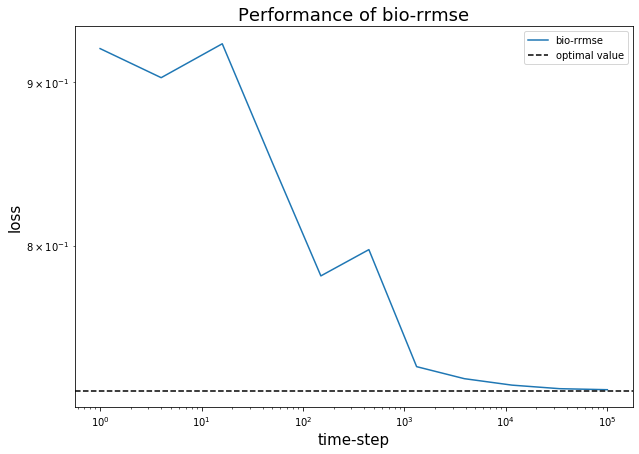

In [8]:
bio_rrmse_run = run_rrmse( Z_dim = 2, method = 'bio-rrmse', epochs = 10,
              eta_decay = 1000, eta_init = 0.013,
              Qratio = .4, Vyratio=1)

Sample 0:
Loss value: 0.91469

Sample 20000:
Loss value: 0.72227

Sample 40000:
Loss value: 0.72167

Sample 60000:
Loss value: 0.72147

Sample 80000:
Loss value: 0.72136

Sample 100000:
Loss value: 0.72128


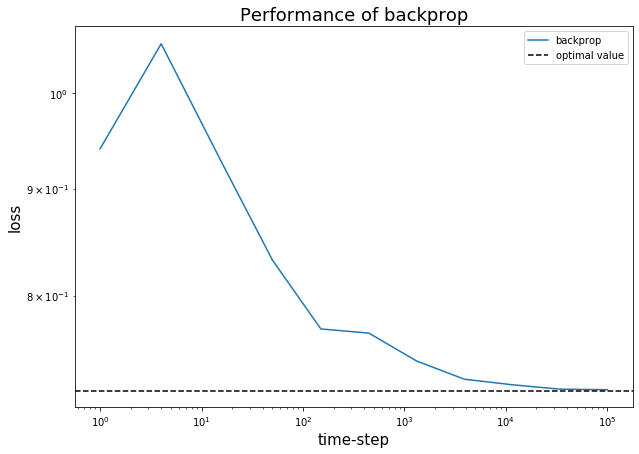

In [9]:
backprop_run = run_rrmse( Z_dim = 2, method = 'backprop', epochs = 10,
              eta_decay = 1000, eta_init = 0.018)

### Comparison plot vs baseline

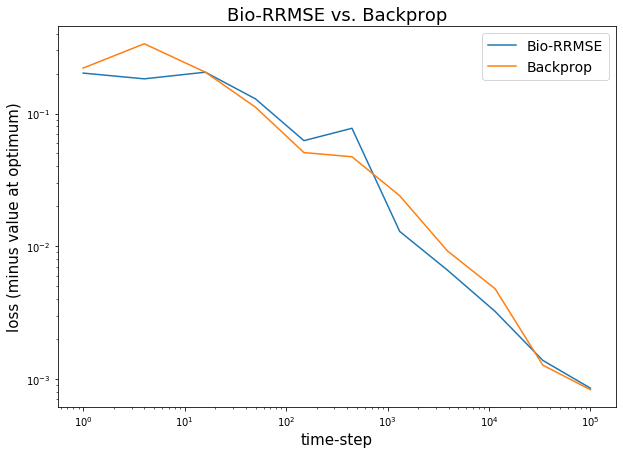

In [10]:
plt.figure(figsize=(10,7))
plotspace = np.logspace(np.log10(2),np.log10(10*num_samples),11).astype(int) -1
plt.loglog(plotspace, np.array(bio_rrmse_run) - baseline, label='Bio-RRMSE')
plt.loglog(plotspace, np.array(backprop_run) - baseline, label='Backprop')
plt.title('Bio-RRMSE vs. Backprop', fontsize=18)
plt.xlabel('time-step', fontsize = 15)
plt.ylabel('loss (minus value at optimum)', fontsize=15)
plt.legend(fontsize=14)

plt.show()